<h1> Standardiztion of the input </h1>

Let's stadardize the input with an normalization layer in keras. 

In [1]:
import myfunctions as mf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
from scipy.optimize import curve_fit
import time
import random

In [2]:
# load data
rootfile = uproot.open("./stage1_clusters_bigdata.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clusters5x5, coord, ind_del = mf.form_cluster(xMC, yMC, EMC)
clusters = clusters5x5.reshape((clusters5x5.shape[0], 25))

This took  164.08751106262207 s


In [4]:
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)

In [5]:
# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

Define the network:

In [6]:
model = keras.Sequential([layers.Input(shape=(25)),
                         layers.LayerNormalization(axis=1),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 25)                50        
_________________________________________________________________
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2

In [9]:
a = time.time()
fit_hist = model.fit(clusters_t, training, batch_size=50, epochs=50, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/50
10353/10353 [==============================] - 21s 2ms/step - loss: 26.2674 - val_loss: 0.0674
Epoch 2/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0755 - val_loss: 0.0627
Epoch 3/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0623 - val_loss: 0.0531
Epoch 4/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0565 - val_loss: 0.0358
Epoch 5/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0519 - val_loss: 0.0633
Epoch 6/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0488 - val_loss: 0.0204
Epoch 7/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0467 - val_loss: 0.0197
Epoch 8/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0442 - val_loss: 0.0475
Epoch 9/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0411 - val_loss: 0.0187
Epoch 10/50
10353/10353 [=============================

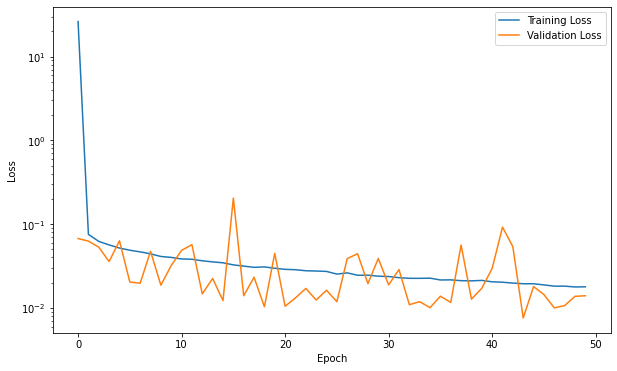

In [10]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [11]:
output = model.predict(clusters_v)

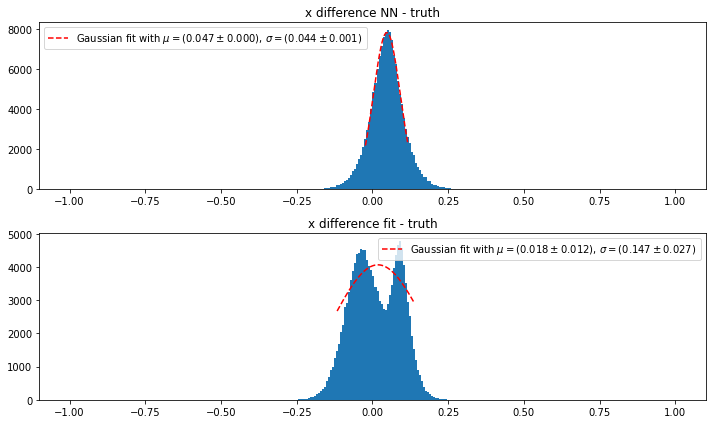

(array([4.74497141e-02, 4.42817359e-02, 8.68165962e+02]),
 array([3.89860223e-04, 5.07973672e-04, 8.03155302e+00]),
 array([1.81492250e-02, 1.47273909e-01, 1.50082021e+03]),
 array([1.16207871e-02, 2.74487217e-02, 2.33705332e+02]))

In [12]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x")

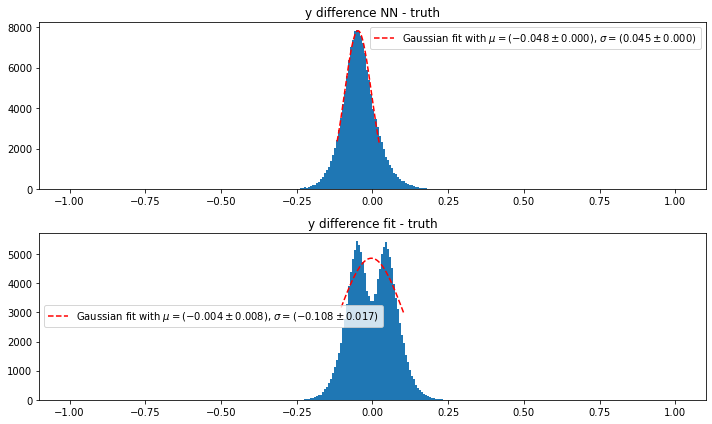

(array([-4.77533019e-02,  4.45026157e-02,  8.71607048e+02]),
 array([3.51135710e-04, 4.60471887e-04, 7.26145320e+00]),
 array([-3.59335380e-03, -1.07901939e-01,  1.31559350e+03]),
 array([7.84167892e-03, 1.66460001e-02, 1.64990425e+02]))

In [13]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

<h2> summary </h2>

| (x/y) | $\mu$ | $\sigma$ |
| --- | --- | --- |
| simplest model  |0.035 / 0.040 | 0.054 / 0.044 |
| simplest model & standardization | 0.047 / 0.048  | 0.044 / 0.045 |

The standardization didn't help much. If one looks at the training vs validation loss, one can see that this is not optional and probably the key for better learning. Adjusting the trainings rate?